# Trabalho Prático 2 – Aprendizado Não Supervisionado  
## Segmentação de Clientes com Algoritmos de Clusterização

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juniors719/customer_personality_clustering/blob/main/customer_segmentation.ipynb)

### Equipe:
* Francisco Djalma Pereira da Silva Júnior - 554222
* Francisco Leudes Bezerra Neto - 552478
* Pablo Vinícius da Silva Araújo - 574229

### Objetivo:
O objetivo principal deste projeto é aplicar, comparar e avaliar o desempenho de três algoritmos de clusterização distintos a um conjunto de dados real. O processo envolve todas as etapas de um projeto de ciência de dados, desde a exploração e pré-processamento dos dados até a aplicação dos modelos e a interpretação dos resultados. Ao final, buscamos identificar segmentos (clusters) de clientes com perfis e comportamentos semelhantes, que possam ser utilizados para direcionar estratégias de marketing mais eficazes.

### Descrição do Conjunto de Dados:
Para este trabalho, foi selecionado o dataset **"Customer Personality Analysis"**, disponível publicamente na plataforma Kaggle.
* **Fonte:** [Kaggle - Customer Personality Analysis](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)
* **Amostras:** O dataset original contém **2.240** registros de clientes.
* **Características:** Possui **29** atributos (features) que detalham o perfil de cada consumidor em quatro categorias principais:
    * **Pessoas:** Dados demográficos como ano de nascimento, educação, estado civil e renda.
    * **Produtos:** Gastos em diferentes categorias de produtos (vinhos, carnes, frutas, etc.).
    * **Promoções:** Engajamento dos clientes com campanhas de marketing anteriores.
    * **Lugar:** Canais de compra utilizados pelos clientes (loja física, site, catálogo).

Este conjunto de dados é ideal para a tarefa de clusterização, pois não possui rótulos predefinidos (variável alvo), característica típica de problemas de aprendizado não supervisionado. A riqueza de atributos comportamentais e demográficos torna possível a identificação de segmentos relevantes.

### Algoritmos Utilizados

- **K-Means:** Rápido e eficiente para grandes datasets; assume clusters esféricos e de tamanho similar.
- **Hierárquico (Aglomerativo):** Permite análise mais interpretável via dendrograma; não requer definição prévia do número de clusters.
- **DBSCAN:** Identifica clusters de formatos arbitrários e detecta outliers naturalmente.

### Pipeline do Projeto
1. Importação e visualização inicial dos dados
2. Limpeza de dados e engenharia de atributos
3. Análise exploratória e identificação de outliers
4. Pré-processamento (normalização e codificação)
5. Aplicação dos algoritmos de clusterização
6. Avaliação e comparação dos modelos
7. Visualização com PCA e t-SNE
8. Perfilamento e interpretação dos clusters

### Divisão de Tarefas:

| Etapa                                          | Djalma | Leudes | Pablo |
|------------------------------------------------|:------:|:------:|:-----:|
| Escolha do dataset e definição do problema     |   ✔    |   ✔    |   ✔   |
| Importação e visualização inicial dos dados    |        |   ✔    |       |
| Limpeza e engenharia de features               |   ✔    |        |       |
| Análise exploratória e remoção de outliers     |        |        |   ✔   |
| Pré-processamento (encoding e scaling)         |   ✔    |        |   ✔   |
| Modelagem com K-Means                          |   ✔    |        |       |
| Modelagem com Clusterização Hierárquica        |        |   ✔    |       |
| Modelagem com DBSCAN                           |        |        |   ✔   |
| Avaliação dos modelos                          |   ✔    |   ✔    |   ✔   |
| Visualização dos clusters (PCA e t-SNE)        |   ✔    |        |       |
| Conclusão e perfilamento                       |   ✔    |   ✔    |   ✔   |


# Importação de bibliotecas


In [119]:
# Importação das bibliotecas para manipulação de dados, matemática e visualização
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importação das ferramentas de Machine Learning do Scikit-learn que serão usadas
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Importação de bibliotecas para ajudar com a visualização e avisos
import warnings
from scipy.cluster.hierarchy import dendrogram, linkage

# --- CONFIGURAÇÕES GERAIS ---
# Ignorar avisos de bibliotecas para um output mais limpo
warnings.filterwarnings("ignore")
# Define um estilo visual padrão para os gráficos
sns.set_style("whitegrid")


import missingno as mn

# Leitura do dataset

In [120]:
try:
    # O arquivo 'marketing_campaign.csv' deve estar na mesma pasta que o seu notebook
    url = "https://raw.githubusercontent.com/juniors719/customer_personality_clustering/refs/heads/main/marketing_campaign.csv"
    df = pd.read_csv(url, sep='\t')
    print("--- Dataset Carregado com Sucesso! ---")
    print(f"O dataset tem {df.shape[0]} linhas e {df.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: O arquivo 'marketing_campaign.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o arquivo está na mesma pasta que o seu notebook.")

--- Dataset Carregado com Sucesso! ---
O dataset tem 2240 linhas e 29 colunas.


# Primeira análise do dataset

In [121]:
# 1. Visualização das primeiras linhas do dataset
print("\n--- Visualizando as 5 primeiras linhas do dataset: ---")
display(df.head())


--- Visualizando as 5 primeiras linhas do dataset: ---


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


### Verificação de Tipos de Dados e Contagem de Nulos

O `.info()` nos dá uma visão rápida sobre os tipos de dados e a presença de valores nulos.

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Estatísticas Descritivas (Numéricas)

O `.describe()` resume as principais métricas estatísticas das colunas numéricas.

In [123]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
ID,2240.0,5592.159821,3246.662198,0.0,2828.25,5458.5,8427.75,11191.0
Year_Birth,2240.0,1968.805804,11.984069,1893.0,1959.00,1970.0,1977.00,1996.0
Income,2216.0,52247.251354,25173.076661,1730.0,35303.00,51381.5,68522.00,666666.0
Kidhome,2240.0,0.444196,0.538398,0.0,0.00,0.0,1.00,2.0
Teenhome,2240.0,0.506250,0.544538,0.0,0.00,0.0,1.00,2.0
Recency,2240.0,49.109375,28.962453,0.0,24.00,49.0,74.00,99.0
MntWines,2240.0,303.935714,336.597393,0.0,23.75,173.5,504.25,1493.0
MntFruits,2240.0,26.302232,39.773434,0.0,1.00,8.0,33.00,199.0
MntMeatProducts,2240.0,166.950000,225.715373,0.0,16.00,67.0,232.00,1725.0
MntFishProducts,2240.0,37.525446,54.628979,0.0,3.00,12.0,50.00,259.0


### Contagem de Valores Nulos por Coluna

A presença de dados ausentes é um dos problemas mais comuns em projetos de ciência de dados. É crucial identificá-los e tratá-los corretamente, pois a maioria dos algoritmos de Machine Learning não funciona com valores nulos.

**O Impacto dos Dados Ausentes:**

- **Redução do Poder Estatístico:** A ausência de dados diminui o tamanho da amostra, o que pode enfraquecer os resultados de testes estatísticos e a confiança nos modelos.
- **Viés nos Resultados:** Se os dados não estiverem faltando de forma completamente aleatória, a sua ausência pode introduzir um viés significativo. Por exemplo, se pessoas com renda mais baixa tendem a não informar sua renda, qualquer análise sobre o impacto da renda no consumo será distorcida.
- **Problemas Técnicos:** Como mencionado, algoritmos como k-Means param ou geram erros ao encontrar valores nulos.

Vamos agora visualizar detalhadamente onde estão os nossos dados ausentes.

In [124]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percentage = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    return pd.concat([total, percentage], axis=1, keys=['Total', 'Porcentagem'])

print("\n\n--- Análise de Dados Ausentes por Coluna ---")
missing_values = missing_data(df)
display(missing_values.style.background_gradient(cmap='Reds'))



--- Análise de Dados Ausentes por Coluna ---


,Total,Porcentagem
Income,24,1.071429
ID,0,0.000000
Year_Birth,0,0.000000
Education,0,0.000000
Marital_Status,0,0.000000
Kidhome,0,0.000000
Teenhome,0,0.000000
Dt_Customer,0,0.000000
Recency,0,0.000000
MntWines,0,0.000000




--- Matriz de Valores Ausentes ---


<Axes: >

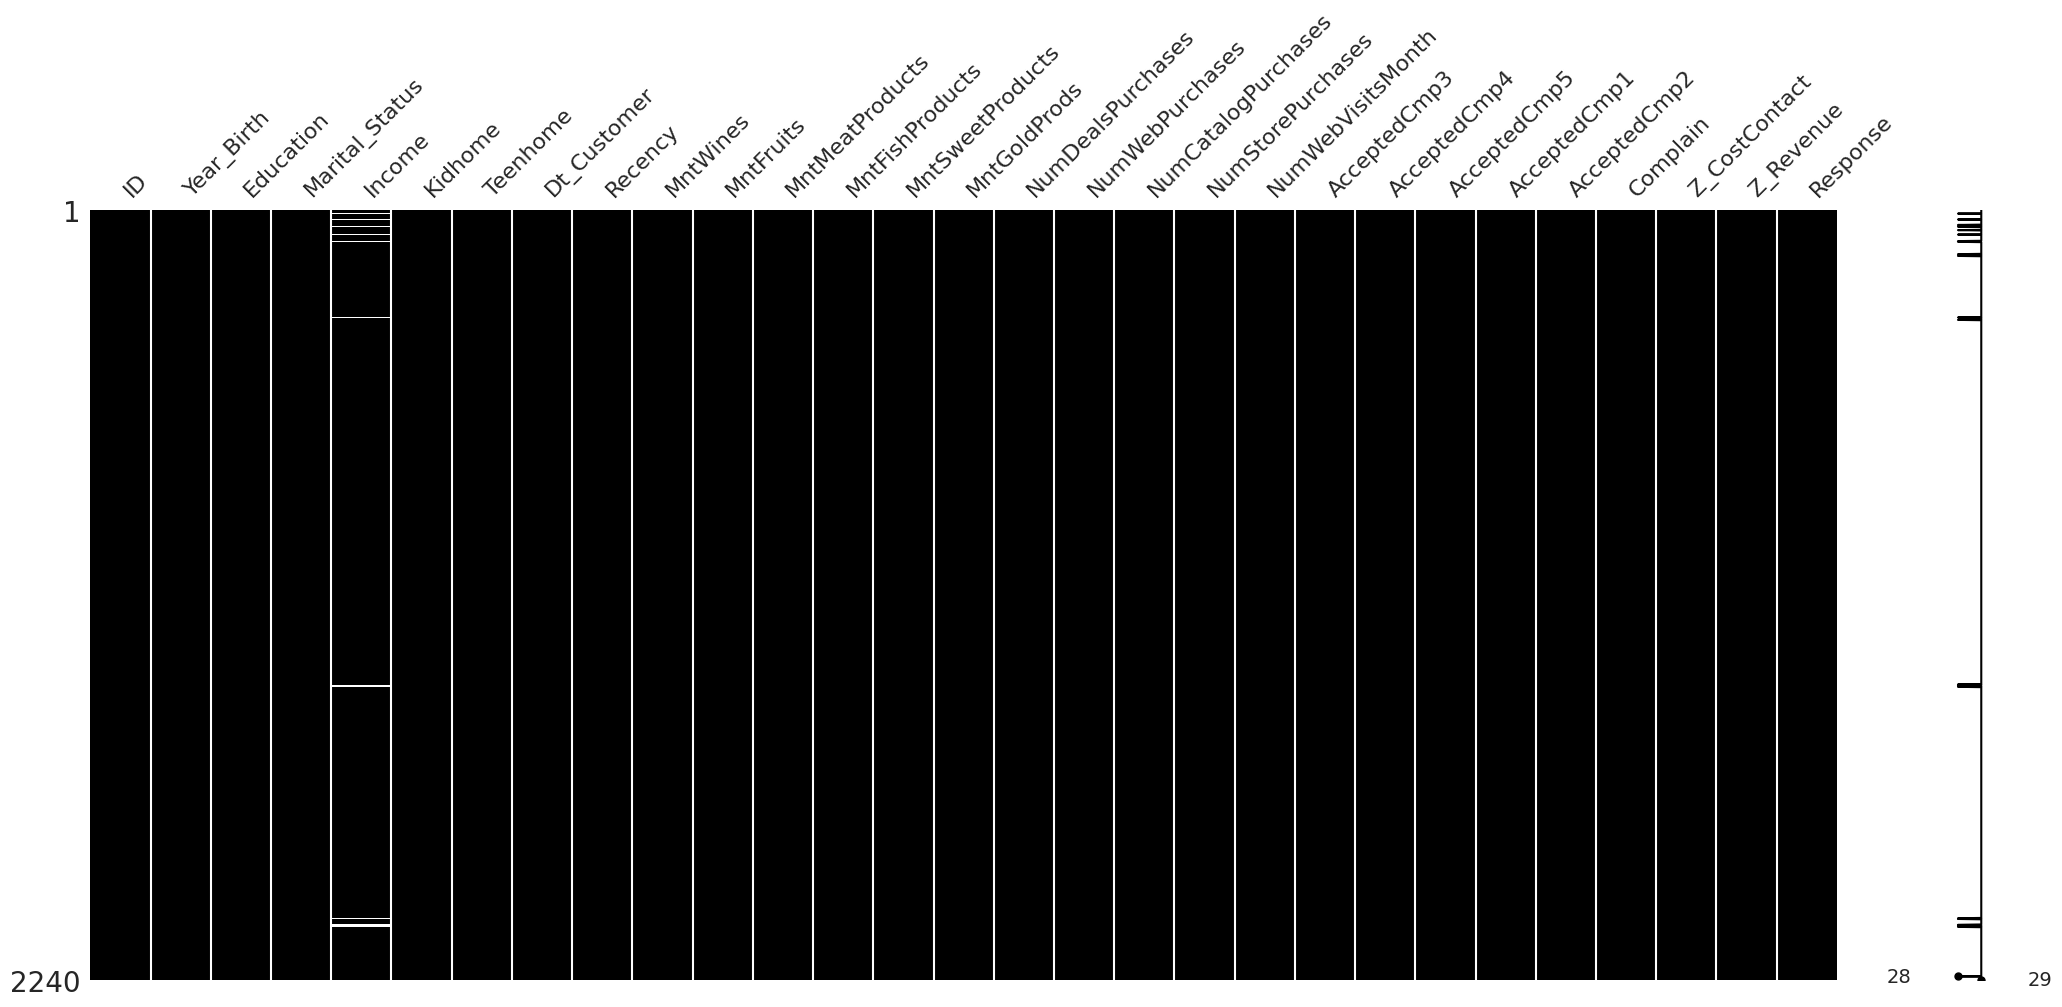

In [125]:
# Visualizar a matriz de valores ausentes
print("\n\n--- Matriz de Valores Ausentes ---")
mn.matrix(df,color = (0,0,0))

###  Verificação de Linhas Duplicadas

In [126]:
num_duplicados = df.duplicated().sum()
print(f"Número de linhas duplicadas encontradas: {num_duplicados}")

Número de linhas duplicadas encontradas: 0


### Contagem de Valores Únicos (Cardinalidade) por Coluna

O `.nunique()` é essencial para identificar colunas constantes.

In [127]:
display(df.nunique())

,0
ID,2240
Year_Birth,59
Education,5
Marital_Status,8
Income,1974
Kidhome,3
Teenhome,3
Dt_Customer,663
Recency,100
MntWines,776


A análise de cardinalidade revelou que as colunas `Z_CostContact` e `Z_Revenue` possuem apenas **1 valor único**. Elas são constantes e serão removidas na etapa de limpeza por não adicionarem informação útil.

### Conclusão da Análise Diagnóstica

A partir da análise diagnóstica, podemos extrair as seguintes conclusões que guiarão nosso próximo passo:

* **Estrutura Confirmada:** O dataset possui **2240 linhas** e **29 colunas**.
* **Dados Ausentes Identificados:** O diagnóstico confirma que a única coluna com valores faltantes é a `Income`, com **24 registros nulos**.
* **Sem Duplicatas:** Não há linhas duplicadas no dataset.
* **Colunas Constantes:** As colunas `Z_CostContact` e `Z_Revenue` possuem apenas um valor único, indicando que não contribuem com informação útil para a clusterização. Elas serão removidas na etapa de limpeza.
* **Necessidade de Pré-processamento:** O dataset contém uma mistura de tipos de dados (numéricos e de texto) que exigirá tratamento (normalização e codificação) antes da modelagem.

# Data Cleaning

In [128]:
df_clean = df.copy()

### Preenchimento de Dados Ausentes

Para lidar com os dados ausentes, uma abordagem comum é preencher os valores nulos com a mediana da coluna correspondente. Isso é especialmente útil para colunas numéricas, como a `Income`, onde a média pode fornecer uma estimativa razoável do valor ausente sem introduzir viés significativo.

In [129]:
income_median = df_clean['Income'].median()
df_clean['Income'].fillna(income_median, inplace=True)
print(f"Valores nulos em 'Income' após imputação: {df_clean['Income'].isnull().sum()}")

Valores nulos em 'Income' após imputação: 0


### Engenharia de Features
A engenharia de features é uma etapa crucial no pré-processamento de dados, onde transformamos e criamos novas variáveis a partir das existentes para melhorar o desempenho dos modelos de Machine Learning.

* **`Idade`**: É uma variável demográfica muito mais intuitiva e diretamente interpretável do que o ano de nascimento.
* **`Gasto_Total`**: Consolida todos os gastos em uma única métrica poderosa que representa o valor total de compra de cada cliente.
* **`Tempo_de_Cliente_dias`**: Mede a longevidade do relacionamento do cliente com a empresa, um excelente indicador de lealdade.
* **`Total_Filhos`** e **`Possui_Filhos`**: Simplificam a estrutura familiar, permitindo analisar de forma direta e eficaz as diferenças de comportamento entre clientes que são pais e os que não são.

In [130]:
# CRIAÇÃO DE FEATURES

# Criação da Feature 'Age' a partir do ano de nascimento
df_clean['Age'] = 2025 - df_clean['Year_Birth']

# Criação da Feature 'Total_Spent' que soma os gastos em diferentes categorias
df_clean['Total_Spent'] = df_clean[[col for col in df.columns if 'Mnt' in col]].sum(axis=1)

# Conversão da coluna 'Dt_Customer' para o formato datetime
df_clean['Dt_Customer'] = pd.to_datetime(df_clean['Dt_Customer'], dayfirst=True)

# Criação da Feature 'Customer_Tenure' que calcula o tempo de relacionamento com o cliente
df_clean['Customer_Tenure'] = (pd.to_datetime('2025-07-06') - df_clean['Dt_Customer']).dt.days # Usando a data da entrega

# Criação da Feature 'Children' que soma as colunas 'Kidhome' e 'Teenhome'
df_clean['Children'] = df_clean['Kidhome'] + df_clean['Teenhome']

# Criação da Feature 'Is_Parent' que indica se o cliente é pai/mãe
df_clean['Is_Parent'] = np.where(df_clean['Children'] > 0, 1, 0)

Para otimizar nosso dataset, vamos agora simplificar algumas colunas categóricas. O objetivo é agrupar categorias que têm um significado semelhante ou que são muito raras, reduzindo o "ruído" nos dados e tornando os padrões mais claros para os algoritmos.

* **`Estado_Civil`**: As diversas categorias serão agrupadas em duas classes principais: `In_Relationship` (para `Married` e `Together`) e `Single` (para as demais). Esta simplificação captura a principal informação sobre a estrutura do domicílio do cliente (vive com um parceiro ou não).
* **`Escolaridade`**: Os diferentes níveis de educação serão consolidados em três grupos mais amplos e significativos: `Undergraduate`, `Graduate` e `Postgraduate`.
* **`Tamanho_Familia`**: Por fim, criaremos uma nova feature combinando o `Estado_Civil` simplificado com o número de filhos (`Total_Filhos`), resultando em uma única e poderosa variável que descreve a composição do lar do cliente.


In [131]:
# SIMPLIFICAÇÃO DE FEATURES

# Simplificação da coluna 'Marital_Status', a fim de agrupar estados civis semelhantes.
df_clean['Marital_Status'] = df_clean['Marital_Status'].replace({
    'Married': 'In_Relationship',
    'Together': 'In_Relationship',
    'Single': 'Single',
    'Divorced': 'Single',
    'Widow': 'Single',
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
})

# Simplificação da coluna 'Education', agrupando níveis de escolaridade semelhantes.
df_clean['Education'] = df_clean['Education'].replace({
    'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Graduate',
    'Master': 'Postgraduate', 'PhD': 'Postgraduate'
})

# Criação de Feature Combinada
df_clean['Family_Size'] = df_clean['Marital_Status'].map({'Single': 1, 'In_Relationship': 2}) + df_clean['Children']

Após a criação de novas features mais informativas, algumas das colunas originais se tornaram redundantes ou são irrelevantes para a modelagem. Para criar um dataset final mais limpo e focado, vamos remover os seguintes grupos de colunas:

* **Identificadores:** A coluna `ID` é apenas um identificador único de cliente e não contém informação sobre seu comportamento.
* **Features Redundantes:** As colunas `Year_Birth` e `Dt_Customer` já foram utilizadas para criar `Idade` e `Tempo_de_Cliente_dias`, respectivamente. Da mesma forma, `Kidhome` e `Teenhome` foram consolidadas na feature `Total_Filhos`. Manter as originais apenas adicionaria informação repetida.
* **Features Constantes:** As colunas `Z_CostContact` e `Z_Revenue` foram identificadas na análise diagnóstica como constantes (possuem o mesmo valor para todos os clientes) e, portanto, não têm poder preditivo.

A remoção dessas colunas resultará em um dataset mais enxuto e eficiente para a etapa de clusterização.

In [132]:
# REMOÇÃO DE FEATURES INÚTEIS

to_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']
df_clean.drop(columns=to_drop, inplace=True)
print(f"\nColunas removidas do dataset: {to_drop}")


Colunas removidas do dataset: ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']


Para facilitar a leitura, a interpretação dos gráficos e a análise dos resultados, todas as colunas do dataframe `df_clean` foram traduzidas para o português. Esta etapa melhora a clareza do notebook e torna a comunicação dos insights mais direta e intuitiva.

In [133]:
# --- TRADUÇÃO DAS COLUNAS PARA PORTUGUÊS ---

# Dicionário mapeando os nomes originais para os nomes em português
mapeamento_nomes = {
    'Education': 'Escolaridade',
    'Marital_Status': 'Estado_Civil',
    'Income': 'Renda_Anual',
    'Recency': 'Dias_Ultima_Compra',
    'MntWines': 'Gasto_Vinhos',
    'MntFruits': 'Gasto_Frutas',
    'MntMeatProducts': 'Gasto_Carnes',
    'MntFishProducts': 'Gasto_Peixes',
    'MntSweetProducts': 'Gasto_Doces',
    'MntGoldProds': 'Gasto_Ouro',
    'NumDealsPurchases': 'Compras_com_Desconto',
    'NumWebPurchases': 'Compras_pela_Web',
    'NumCatalogPurchases': 'Compras_por_Catalogo',
    'NumStorePurchases': 'Compras_na_Loja',
    'NumWebVisitsMonth': 'Visitas_no_Site_Mes',
    'AcceptedCmp3': 'Aceitou_Campanha_3',
    'AcceptedCmp4': 'Aceitou_Campanha_4',
    'AcceptedCmp5': 'Aceitou_Campanha_5',
    'AcceptedCmp1': 'Aceitou_Campanha_1',
    'AcceptedCmp2': 'Aceitou_Campanha_2',
    'Complain': 'Reclamou_2_Anos',
    'Response': 'Aceitou_Ultima_Campanha',
    'Age': 'Idade',
    'Total_Spent': 'Gasto_Total',
    'Customer_Tenure': 'Tempo_de_Cliente_dias',
    'Children': 'Total_Filhos',
    'Is_Parent': 'Possui_Filhos',
    'Family_Size': 'Tamanho_Familia'
}

df_clean.rename(columns=mapeamento_nomes, inplace=True)

print("\n--- Colunas traduzidas para o português ---")
print("Visualizando o dataframe com os novos nomes de colunas:")
display(df_clean.head())


--- Colunas traduzidas para o português ---
Visualizando o dataframe com os novos nomes de colunas:


,Escolaridade,Estado_Civil,Renda_Anual,Dias_Ultima_Compra,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Ouro,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Reclamou_2_Anos,Aceitou_Ultima_Campanha,Idade,Gasto_Total,Tempo_de_Cliente_dias,Total_Filhos,Possui_Filhos,Tamanho_Familia
0,Graduate,Single,58138.0,58,635,88,546,172,88,88,...,0,0,0,1,68,1617,4688,0,0,1
1,Graduate,Single,46344.0,38,11,1,6,2,1,6,...,0,0,0,0,71,27,4138,2,1,3
2,Graduate,In_Relationship,71613.0,26,426,49,127,111,21,42,...,0,0,0,0,60,776,4337,0,0,2
3,Graduate,In_Relationship,26646.0,26,11,4,20,10,3,5,...,0,0,0,0,41,53,4164,1,1,3
4,Postgraduate,In_Relationship,58293.0,94,173,43,118,46,27,15,...,0,0,0,0,44,422,4186,1,1,3


# Análise Exploratória

Agora que nossos dados estão limpos e enriquecidos, vamos iniciar a análise exploratória visual. Começaremos com uma **análise univariada**, ou seja, analisando uma variável de cada vez para entender suas características individuais.

### Análise Univariada

Usaremos **histogramas** para visualizar a distribuição de duas das nossas features mais importantes: `Idade` e `Gasto_Total`.

* **Histograma de Idade:** Nos ajudará a entender a faixa etária predominante dos nossos clientes. Existem mais clientes jovens, de meia-idade ou mais velhos? A distribuição é uniforme ou concentrada em algum grupo?
* **Histograma de Gasto Total:** Revelará a distribuição do poder de compra. É provável que encontremos uma **assimetria à direita**, onde a maioria dos clientes tem um gasto moderado e uma minoria de "high-rollers" gasta valores muito mais altos.

Compreender essas distribuições é o primeiro passo para identificar os diferentes perfis de clientes que compõem nossa base.

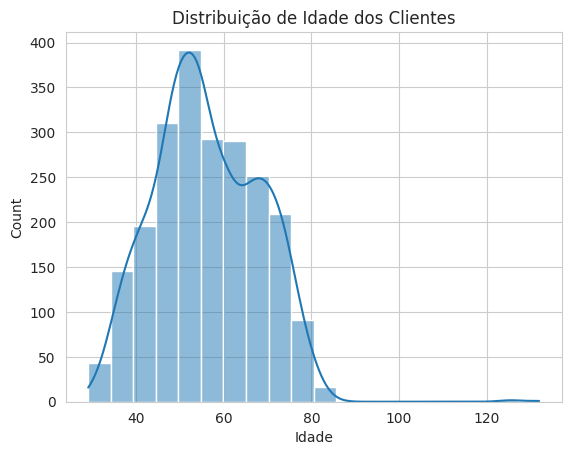

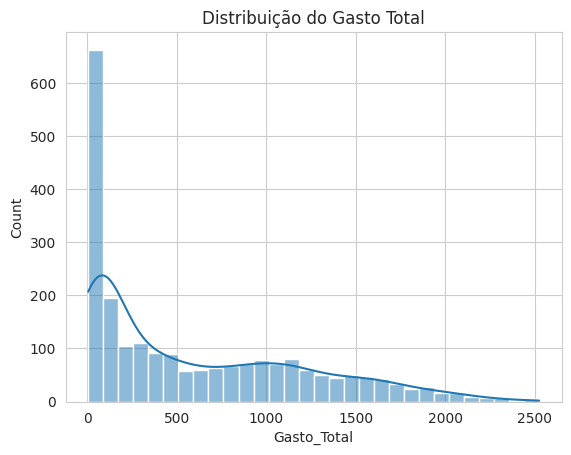

In [134]:
# Verificar distribuição de idade
sns.histplot(df_clean['Idade'], bins=20, kde=True)
plt.title('Distribuição de Idade dos Clientes')
plt.show()

# Gasto Total
sns.histplot(df_clean['Gasto_Total'], bins=30, kde=True)
plt.title('Distribuição do Gasto Total')
plt.show()

### Análise Visual para Identificação de Outliers

Para aprofundar nossa análise e preparar os dados para a clusterização, é essencial identificar a presença de **outliers**. Outliers são pontos de dados que se desviam significativamente do resto do conjunto e podem distorcer os resultados de algoritmos sensíveis à distância, como o k-Means.

A ferramenta visual mais eficaz para esta tarefa é o **Boxplot**. Ele nos permite visualizar:
* A **mediana** (a linha central).
* O **intervalo interquartil (IQR)** (a "caixa", que contém 50% dos dados centrais).
* Os **"bigodes" (whiskers)**, que representam o alcance esperado dos dados.
* E, mais importante, os **pontos individuais fora dos bigodes**, que são os nossos potenciais outliers.

Vamos gerar boxplots para as nossas principais variáveis contínuas: `Renda_Anual`, `Idade` e `Gasto_Total`.

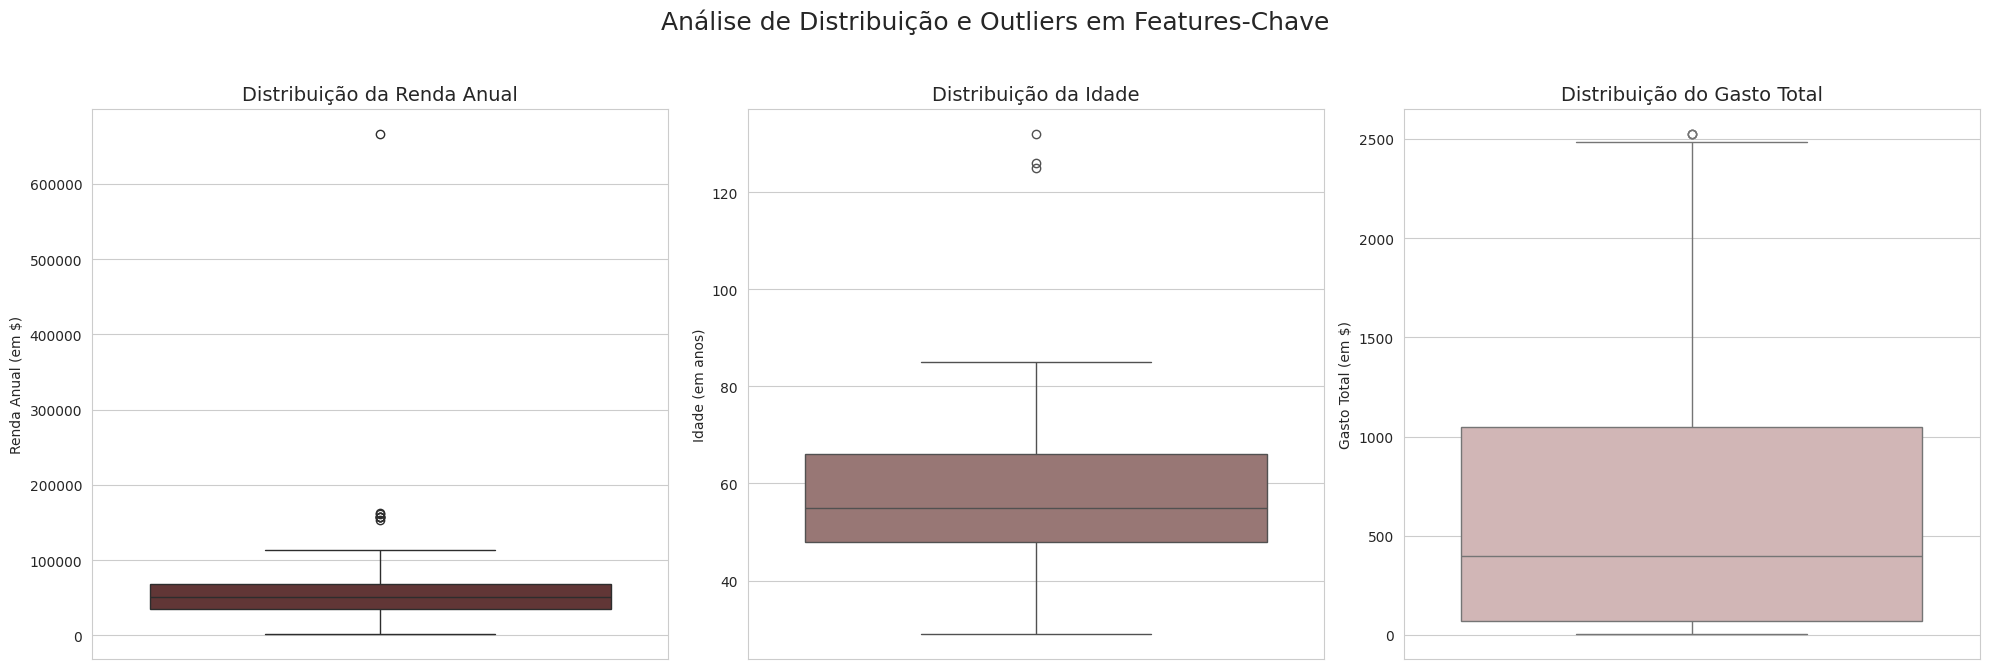

In [135]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('Análise de Distribuição e Outliers em Features-Chave', fontsize=18)

# Usaremos a paleta de cores que definimos no início
PALETTE = ["#682F2F", "#9E726F", "#D6B2B1"]

# Gráfico 1: Boxplot da Renda Anual
sns.boxplot(ax=axes[0], data=df_clean, y='Renda_Anual', color=PALETTE[0])
axes[0].set_title('Distribuição da Renda Anual', fontsize=14)
axes[0].set_ylabel('Renda Anual (em $)')

# Gráfico 2: Boxplot da Idade
sns.boxplot(ax=axes[1], data=df_clean, y='Idade', color=PALETTE[1])
axes[1].set_title('Distribuição da Idade', fontsize=14)
axes[1].set_ylabel('Idade (em anos)')

# Gráfico 3: Boxplot do Gasto Total
sns.boxplot(ax=axes[2], data=df_clean, y='Gasto_Total', color=PALETTE[2])
axes[2].set_title('Distribuição do Gasto Total', fontsize=14)
axes[2].set_ylabel('Gasto Total (em $)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Remoção de Outliers

A análise visual da etapa anterior, especialmente através dos boxplots, confirmou a presença de valores extremos (outliers) nas colunas `Renda_Anual` e `Idade`. Estes pontos, embora poucos, podem distorcer significativamente o cálculo das distâncias e a formação dos clusters, levando a um modelo menos preciso e representativo da maioria dos clientes.

Para mitigar esse risco, vamos remover esses registros do nosso dataset. Adotaremos os seguintes critérios de corte:
* **Renda Anual:** Manteremos apenas clientes com renda inferior a 200.000.
* **Idade:** Manteremos apenas clientes com idade inferior a 90 anos.

Esta limpeza resultará em um conjunto de dados mais robusto e preparado para a etapa de modelagem.

In [136]:
# --- REMOÇÃO DE OUTLIERS ---

# Guardamos o número de linhas antes da remoção para verificar o impacto
linhas_antes = df_clean.shape[0]

# Filtramos o dataframe para manter apenas os clientes com Renda_Anual < 200.000 e Idade < 90
# Usamos .copy() para garantir que estamos criando um novo dataframe independente
df_sem_outliers = df_clean[(df_clean['Renda_Anual'] < 200000) & (df_clean['Idade'] < 90)].copy()

linhas_depois = df_sem_outliers.shape[0]
outliers_removidos = linhas_antes - linhas_depois

print("--- Remoção de Outliers Concluída ---")
print(f"Número de linhas original: {linhas_antes}")
print(f"Número de linhas após remover outliers: {linhas_depois}")
print(f"Total de outliers removidos: {outliers_removidos}")

# O nosso novo dataframe de trabalho agora é o 'df_sem_outliers'

--- Remoção de Outliers Concluída ---
Número de linhas original: 2240
Número de linhas após remover outliers: 2236
Total de outliers removidos: 4


### Análise de Correlação entre Features-Chave

Para finalizar nossa análise exploratória, vamos investigar a **correlação linear** entre as principais variáveis numéricas do nosso conjunto de dados. A correlação mede a força e a direção da relação entre duas variáveis.

Usaremos um **mapa de calor (heatmap)** para visualizar a matriz de correlação. Esta é uma forma gráfica e intuitiva de identificar rapidamente quais variáveis se movem juntas.

**Como interpretar o mapa de calor:**
* **Cores Quentes (próximas ao vermelho - valor próximo de +1):** Indicam uma **correlação positiva forte**. Quando uma variável aumenta, a outra tende a aumentar também. Esperamos ver isso entre `Renda_Anual` e `Gasto_Total`.
* **Cores Frias (próximas ao azul - valor próximo de -1):** Indicam uma **correlação negativa forte**. Quando uma variável aumenta, a outra tende a diminuir.
* **Cores Neutras (próximas ao branco/cinza - valor próximo de 0):** Indicam pouca ou nenhuma correlação linear.

Esta análise nos ajudará a entender as relações subjacentes no comportamento dos clientes antes de aplicarmos os algoritmos de clusterização.

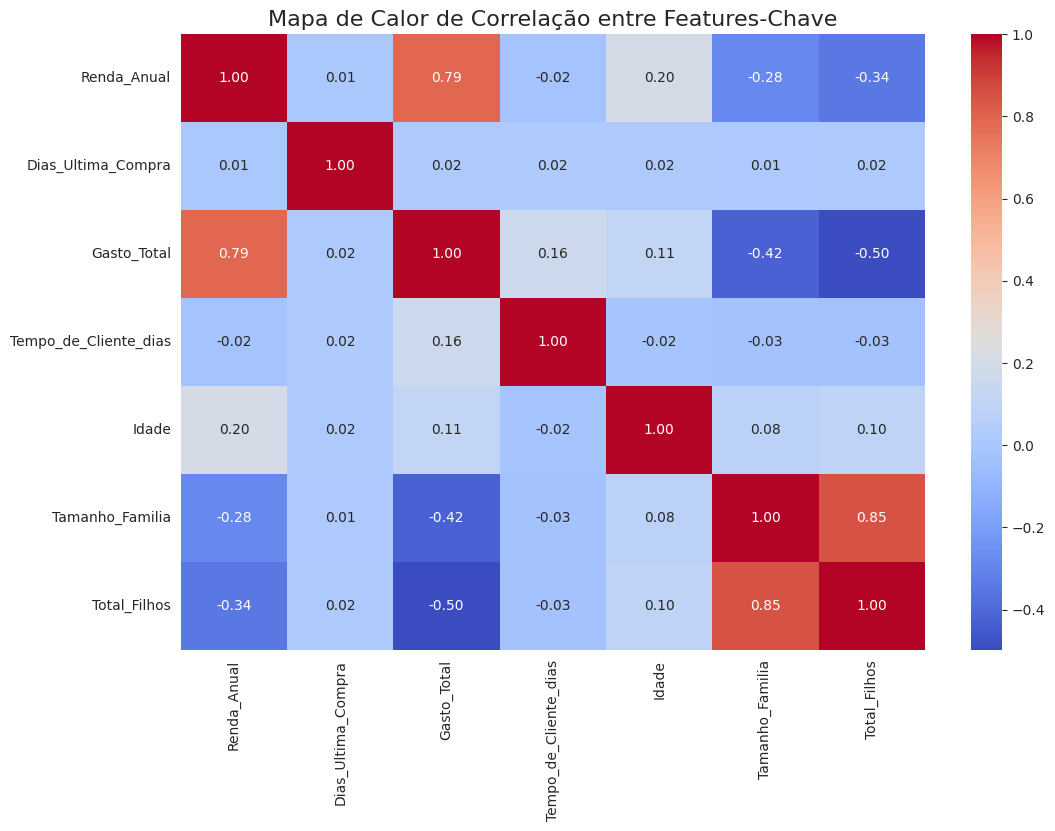

In [137]:
# --- MAPA DE CALOR DE CORRELAÇÃO ---

# Selecionando as colunas numéricas mais relevantes para a correlação
# Usamos o dataframe já sem outliers e com colunas em português
cols_para_corr = [
    'Renda_Anual', 'Dias_Ultima_Compra', 'Gasto_Total',
    'Tempo_de_Cliente_dias', 'Idade', 'Tamanho_Familia', 'Total_Filhos'
]

# Calculando a matriz de correlação
matriz_corr = df_sem_outliers[cols_para_corr].corr()

# Criando o mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(
    matriz_corr,
    annot=True,     # Mostra os valores de correlação no gráfico
    fmt=".2f",      # Formata os números para duas casas decimais
    cmap='coolwarm' # Paleta de cores: quente para positivo, frio para negativo
)
plt.title('Mapa de Calor de Correlação entre Features-Chave', fontsize=16)
plt.show()

* **Correlação Positiva Forte (Renda vs. Gasto):** A observação mais clara é a forte correlação positiva (aproximadamente **+0.79**) entre `Renda_Anual` e `Gasto_Total`. Isso confirma a hipótese intuitiva de que clientes com maior renda tendem a gastar mais. Esta será, provavelmente, uma das variáveis mais importantes para a segmentação dos nossos clientes.

* **Correlação Negativa (Filhos vs. Gasto):** Existe uma correlação negativa moderada (aproximadamente **-0.50**) entre `Total_Filhos` e `Gasto_Total`. Isso sugere que, em geral, clientes com mais filhos tendem a ter um gasto total menor nos produtos da nossa loja, possivelmente por terem outras prioridades financeiras.

* **Correlação Moderada (Idade e Tempo de Cliente):** A `Idade` e o `Tempo_de_Cliente_dias` também mostram uma correlação positiva com o `Gasto_Total`. Isso indica que clientes mais velhos e mais leais (com mais tempo de casa) tendem a gastar mais.

* **Pouca Correlação (Recência):** A variável `Dias_Ultima_Compra` (Recência) parece ter uma correlação muito fraca com as outras variáveis, sugerindo que o tempo desde a última compra não está fortemente ligado de forma linear à renda ou ao gasto total nesta visão geral.

# Pré-processamento

### Label Encoding
Converteremos as variáveis categóricas remanescentes (`Escolaridade` e `Estado_Civil`) em representações numéricas, pois os algoritmos de clusterização não processam texto.

In [138]:
# --- PASSO 4: EXECUÇÃO DO ENCODING E SCALING ---

# Criamos uma cópia do dataframe já limpo para esta etapa final
df_processed = df_sem_outliers.copy()

# 1. ENCODING DE VARIÁVEIS CATEGÓRICAS
# Seleciona as colunas de texto (tipo 'object')
categorical_cols = df_processed.select_dtypes(include='object').columns

print("--- Codificando as seguintes colunas categóricas: ---")
print(categorical_cols)

# Aplica o LabelEncoder para transformar texto em números
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

--- Codificando as seguintes colunas categóricas: ---
Index(['Escolaridade', 'Estado_Civil'], dtype='object')


### Normalização

Padronizar todas as colunas para que tenham média 0 e desvio padrão 1. Isso evita que variáveis com valores grandes (como Renda_Anual) dominem o processo de clusterização.

In [139]:
# 2. NORMALIZAÇÃO (STANDARD SCALING)
# Instancia o Scaler
scaler = StandardScaler()

# Treina o scaler e transforma o dataframe
scaled_features = scaler.fit_transform(df_processed)

# Converte o array de volta para um dataframe do pandas com os nomes das colunas
# Este é o nosso dataframe final e pronto para a modelagem!
df_ready = pd.DataFrame(scaled_features, columns=df_processed.columns)

In [140]:
# --- RESULTADO DA ETAPA ---
print("\n--- Dataset 100% pronto para a clusterização ---")
print("Todas as features são numéricas e estão na mesma escala.")
display(df_ready.head())


--- Dataset 100% pronto para a clusterização ---
Todas as features são numéricas e estão na mesma escala.


,Escolaridade,Estado_Civil,Renda_Anual,Dias_Ultima_Compra,Gasto_Vinhos,Gasto_Frutas,Gasto_Carnes,Gasto_Peixes,Gasto_Doces,Gasto_Ouro,...,Aceitou_Campanha_1,Aceitou_Campanha_2,Reclamou_2_Anos,Aceitou_Ultima_Campanha,Idade,Gasto_Total,Tempo_de_Cliente_dias,Total_Filhos,Possui_Filhos,Tamanho_Familia
0,-0.89438,1.347635,0.288947,0.306856,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,...,-0.262362,-0.116616,-0.095001,2.386338,1.016868,1.680176,1.529793,-1.264308,-1.584362,-1.758810
1,-0.89438,1.347635,-0.262003,-0.383971,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,...,-0.262362,-0.116616,-0.095001,-0.419052,1.273264,-0.962202,-1.191143,1.395139,0.631169,0.445618
2,-0.89438,-0.742041,0.918423,-0.798467,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,...,-0.262362,-0.116616,-0.095001,-0.419052,0.333146,0.282541,-0.206659,-1.264308,-1.584362,-0.656596
3,-0.89438,-0.742041,-1.182183,-0.798467,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.290693,-0.918994,-1.062517,0.065416,0.631169,0.445618
4,0.57070,-0.742041,0.296187,1.550344,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,...,-0.262362,-0.116616,-0.095001,-0.419052,-1.034298,-0.305762,-0.953679,0.065416,0.631169,0.445618


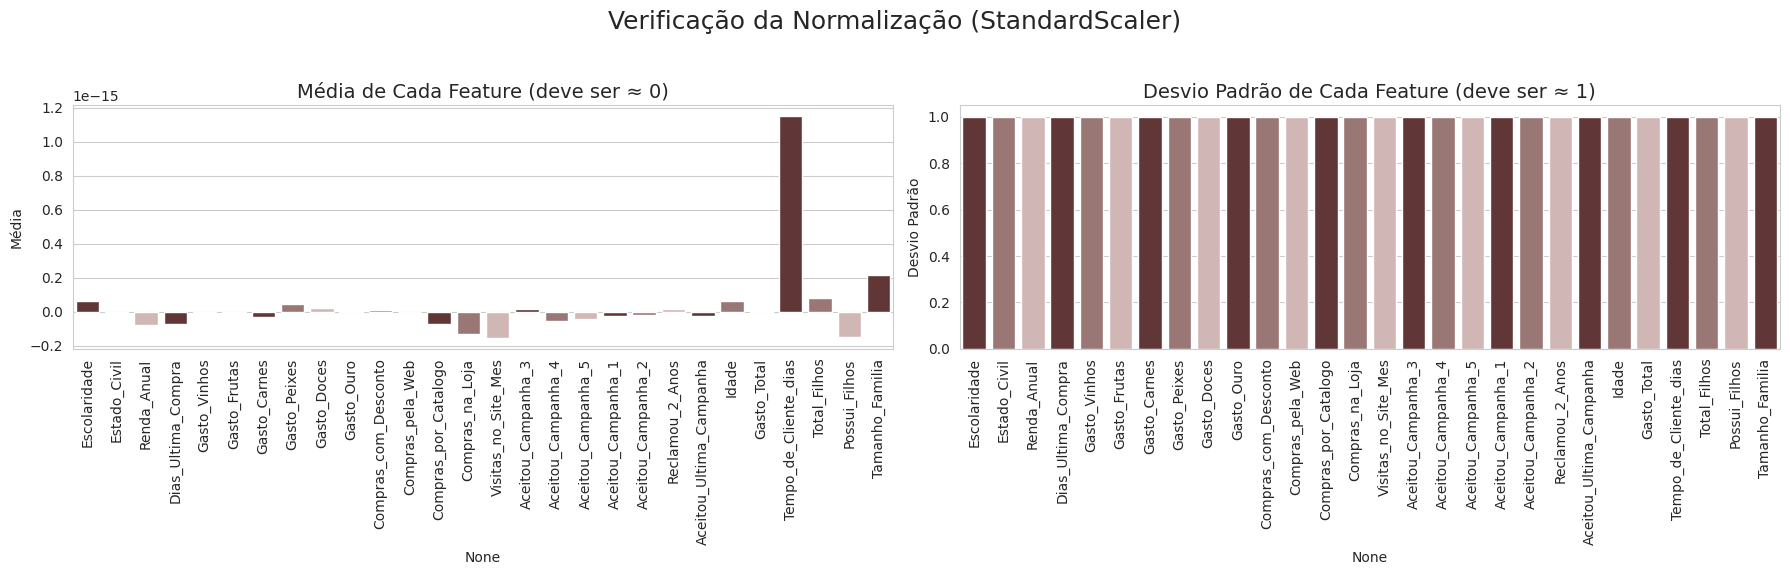


--- Média de cada feature (arredondada para 5 casas decimais): ---
Escolaridade               0.0
Estado_Civil              -0.0
Renda_Anual               -0.0
Dias_Ultima_Compra        -0.0
Gasto_Vinhos              -0.0
Gasto_Frutas              -0.0
Gasto_Carnes              -0.0
Gasto_Peixes               0.0
Gasto_Doces                0.0
Gasto_Ouro                 0.0
Compras_com_Desconto       0.0
Compras_pela_Web           0.0
Compras_por_Catalogo      -0.0
Compras_na_Loja           -0.0
Visitas_no_Site_Mes       -0.0
Aceitou_Campanha_3         0.0
Aceitou_Campanha_4        -0.0
Aceitou_Campanha_5        -0.0
Aceitou_Campanha_1        -0.0
Aceitou_Campanha_2        -0.0
Reclamou_2_Anos            0.0
Aceitou_Ultima_Campanha   -0.0
Idade                      0.0
Gasto_Total                0.0
Tempo_de_Cliente_dias      0.0
Total_Filhos               0.0
Possui_Filhos             -0.0
Tamanho_Familia            0.0
dtype: float64

--- Desvio Padrão de cada feature (arredondado p

In [141]:
# --- VERIFICAÇÃO DO STANDARDSCALER ---

# Calculando a média e o desvio padrão de cada coluna no dataframe normalizado
means = df_ready.mean()
stds = df_ready.std()

# Criando a figura para os gráficos de verificação
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Verificação da Normalização (StandardScaler)', fontsize=18)

# Gráfico 1: Média das Features
sns.barplot(ax=axes[0], x=means.index, y=means.values, palette=PALETTE)
axes[0].set_title('Média de Cada Feature (deve ser ≈ 0)', fontsize=14)
axes[0].set_ylabel('Média')
axes[0].tick_params(axis='x', rotation=90) # Rotaciona os nomes das colunas para não sobrepor

# Gráfico 2: Desvio Padrão das Features
sns.barplot(ax=axes[1], x=stds.index, y=stds.values, palette=PALETTE)
axes[1].set_title('Desvio Padrão de Cada Feature (deve ser ≈ 1)', fontsize=14)
axes[1].set_ylabel('Desvio Padrão')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Exibindo os valores exatos para confirmação numérica
print("\n--- Média de cada feature (arredondada para 5 casas decimais): ---")
print(round(means, 5))
print("\n--- Desvio Padrão de cada feature (arredondado para 5 casas decimais): ---")
print(round(stds, 5))

## Aplicando DBSCAN

Agora aplicaremos o algoritmo de clusterização DBSCAN ao dataset `df_ready`, que está normalizado e pronto.

O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) agrupa pontos de dados que estão próximos uns dos outros (tendo muitas vizinhos próximos), marcando como outliers pontos que se encontram sozinhos em regiões de baixa densidade. Ele não requer que o número de clusters seja especificado a priori, o que é uma vantagem.

Para este algoritmo, precisamos definir dois parâmetros principais:
- `eps`: A distância máxima entre duas amostras para que uma seja considerada como estando na vizinhança da outra.
- `min_samples`: O número de amostras (ou total de peso) em uma vizinhança para que um ponto seja considerado um ponto central (core point).

Após a aplicação, adicionaremos os rótulos dos clusters gerados (`-1` indica ruído/outliers) de volta aos dataframes reduzidos (`df_pca` e `df_tsne`) para visualização.

In [155]:
# --- APLICAÇÃO DO DBSCAN ---

# Instanciar o modelo DBSCAN
dbscan = DBSCAN(eps=7, min_samples=10)

# Aplicar o DBSCAN ao dataframe pronto para modelagem
dbscan_labels = dbscan.fit_predict(df_ready)

# Adicionar os rótulos dos clusters aos dataframes de visualização
df_pca['DBSCAN_Cluster'] = dbscan_labels
df_tsne['DBSCAN_Cluster'] = dbscan_labels

print("--- Aplicação do DBSCAN Concluída ---")
# Usamos value_counts() para obter a contagem de pontos por cluster
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
print(f"Número de clusters encontrados (incluindo ruído -1): {len(np.unique(dbscan_labels))}")
print("\nContagem de pontos por cluster:")
display(cluster_counts)

print("\nVisualizando os primeiros rótulos de cluster gerados pelo DBSCAN:")
display(pd.Series(dbscan_labels).head())

# Verificando se os rótulos foram adicionados aos dataframes de visualização
print("\nVisualizando df_pca com rótulos DBSCAN:")
display(df_pca.head())

print("\nVisualizando df_tsne com rótulos DBSCAN:")
display(df_tsne.head())

--- Aplicação do DBSCAN Concluída ---
Número de clusters encontrados (incluindo ruído -1): 4

Contagem de pontos por cluster:


,count
-1,19
0,2175
1,19
2,23



Visualizando os primeiros rótulos de cluster gerados pelo DBSCAN:


,0
0,0
1,0
2,0
3,0
4,0



Visualizando df_pca com rótulos DBSCAN:


,PC1,PC2,DBSCAN_Cluster
0,4.798362,0.060977,0
1,-2.676531,-0.580347,0
2,2.122174,-0.577682,0
3,-2.660040,-0.945250,0
4,-0.638332,0.647135,0



Visualizando df_tsne com rótulos DBSCAN:


,TSNE1,TSNE2,DBSCAN_Cluster
0,50.554371,-12.305019,0
1,-25.943367,-24.628313,0
2,27.018721,-7.008229,0
3,-37.699120,5.857546,0
4,-12.357054,19.840921,0


## Visualizando Clusters DBSCAN no Espaço PCA

Vamos visualizar os clusters encontrados pelo DBSCAN plotando os pontos no espaço bidimensional do PCA, colorindo-os de acordo com o rótulo do cluster atribuído pelo DBSCAN. Os pontos com rótulo `-1` (ruído) serão visualizados separadamente ou com uma cor distinta, se houver.

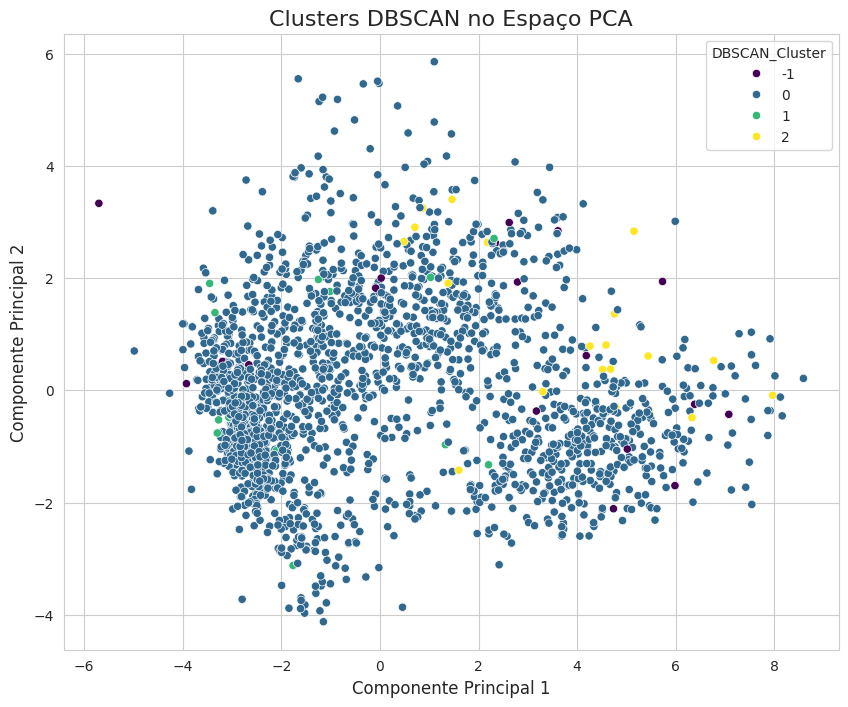

In [156]:
plt.figure(figsize=(10, 8))
# Usamos a coluna 'DBSCAN_Cluster' do dataframe df_pca para colorir os pontos
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=df_pca, palette='viridis', legend='full')
plt.title('Clusters DBSCAN no Espaço PCA', fontsize=16)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.show()

## Visualizando Clusters DBSCAN no Espaço t-SNE

Similar à visualização com PCA, agora plotaremos os clusters do DBSCAN no espaço bidimensional do t-SNE. O t-SNE geralmente preserva melhor as distâncias locais, o que pode revelar estruturas de cluster que não são tão evidentes no PCA.

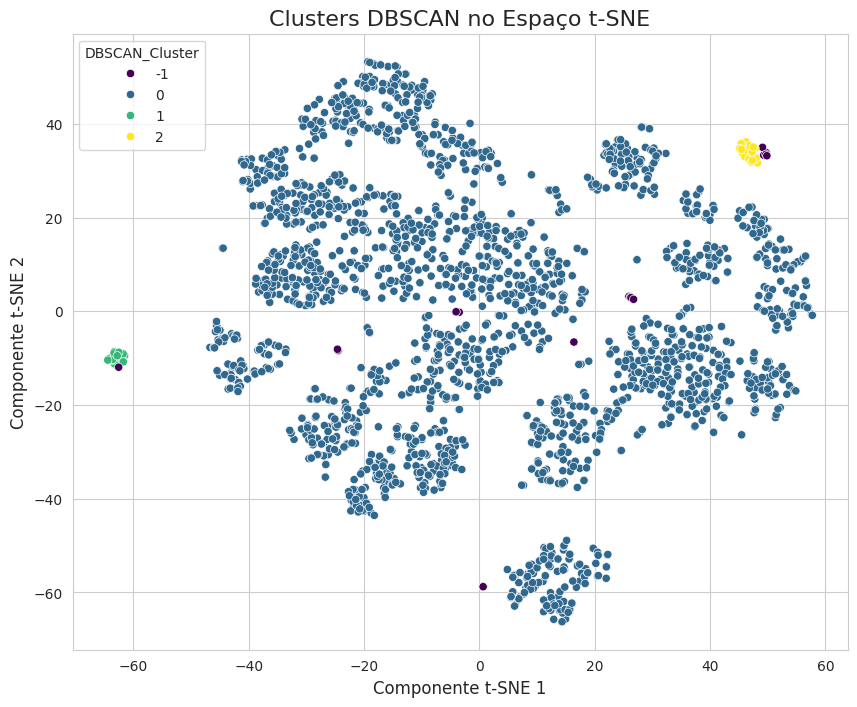

In [157]:
plt.figure(figsize=(10, 8))
# Usamos a coluna 'DBSCAN_Cluster' do dataframe df_tsne para colorir os pontos
sns.scatterplot(x='TSNE1', y='TSNE2', hue='DBSCAN_Cluster', data=df_tsne, palette='viridis', legend='full')
plt.title('Clusters DBSCAN no Espaço t-SNE', fontsize=16)
plt.xlabel('Componente t-SNE 1', fontsize=12)
plt.ylabel('Componente t-SNE 2', fontsize=12)
plt.show()

## Avaliação da Qualidade dos Clusters DBSCAN

Vamos calcular métricas de avaliação para quantificar a qualidade da clusterização obtida com o DBSCAN. Utilizaremos o Silhouette Score, o Davies-Bouldin Index e o Calinski-Harabasz Index.

É importante lembrar que a presença de pontos de ruído (rótulo -1) pode impactar a interpretação dessas métricas. O Silhouette Score e o Davies-Bouldin Index são calculados apenas para os pontos que não são considerados ruído.

In [158]:
# --- AVALIAÇÃO DO DBSCAN ---

# É necessário ter pelo menos 2 clusters (além do ruído) para calcular a maioria das métricas
# Filtra os rótulos para remover os pontos de ruído (-1) para o cálculo das métricas que não os suportam
# Cria uma máscara para selecionar apenas os pontos que pertencem a um cluster (rótulo != -1)
clustered_mask = dbscan_labels != -1
X_clustered = df_ready[clustered_mask]
labels_clustered = dbscan_labels[clustered_mask]

# Verifica se há pelo menos 2 clusters identificados (excluindo ruído)
if len(np.unique(labels_clustered)) < 2:
    print("Não foi possível calcular as métricas de avaliação (Silhouette, Davies-Bouldin, Calinski-Harabasz) pois o DBSCAN encontrou menos de 2 clusters (excluindo ruído).")
    print(f"Número de clusters encontrados (excluindo ruído): {len(np.unique(labels_clustered))}")
else:
    # Calcula o Silhouette Score
    # Um valor mais alto indica melhor separação entre os clusters
    silhouette = silhouette_score(X_clustered, labels_clustered)
    print(f"Silhouette Score (excluindo ruído): {silhouette:.4f}")

    # Calcula o Davies-Bouldin Index
    # Um valor mais baixo indica melhor clusterização
    davies_bouldin = davies_bouldin_score(X_clustered, labels_clustered)
    print(f"Davies-Bouldin Index (excluindo ruído): {davies_bouldin:.4f}")

    # Calcula o Calinski-Harabasz Index
    # Um valor mais alto indica melhor clusterização
    calinski_harabasz = calinski_harabasz_score(X_clustered, labels_clustered)
    print(f"Calinski-Harabasz Index (excluindo ruído): {calinski_harabasz:.4f}")

Silhouette Score (excluindo ruído): 0.4423
Davies-Bouldin Index (excluindo ruído): 0.9203
Calinski-Harabasz Index (excluindo ruído): 91.0345


## Perfilamento dos Clusters DBSCAN

Agora que identificamos uma configuração de parâmetros do DBSCAN que resultou em métricas de avaliação promissoras, vamos analisar as características dos clusters encontrados. O objetivo é entender o perfil de cada grupo de clientes com base nas variáveis originais do dataset.

Vamos focar nos clusters que não são ruído (rótulo != -1).

In [146]:
# Adicionar os rótulos do DBSCAN ao dataframe original (ou df_sem_outliers) para análise de perfil
# É importante usar o dataframe ANTES da normalização para interpretar as features nas suas escalas originais
df_perfilamento_dbscan = df_sem_outliers.copy()
df_perfilamento_dbscan['DBSCAN_Cluster'] = dbscan_labels # dbscan_labels são os rótulos da última execução

# Filtrar os pontos de ruído (-1) para o perfilamento
df_clusters_dbscan = df_perfilamento_dbscan[df_perfilamento_dbscan['DBSCAN_Cluster'] != -1].copy()

print("--- Perfilamento dos Clusters DBSCAN (excluindo ruído) ---")
print(f"Analisando {len(np.unique(df_clusters_dbscan['DBSCAN_Cluster']))} clusters (excluindo ruído).")

# Calcular as estatísticas descritivas para cada cluster
# Podemos calcular a média, mediana, e talvez contagem para ter uma ideia do tamanho do cluster
cluster_profile = df_clusters_dbscan.groupby('DBSCAN_Cluster').agg({
    'Renda_Anual': ['mean', 'median', 'count'],
    'Idade': ['mean', 'median'],
    'Gasto_Total': ['mean', 'median'],
    'Tempo_de_Cliente_dias': ['mean', 'median'],
    'Total_Filhos': ['mean', 'median'],
    'Possui_Filhos': ['mean', 'sum'], # Sum para ver quantos possuem filhos
    'Tamanho_Familia': ['mean', 'median'],
    'Escolaridade': lambda x: x.mode()[0], # Moda para variáveis categóricas codificadas
    'Estado_Civil': lambda x: x.mode()[0], # Moda para variáveis categóricas codificadas
    'Aceitou_Campanha_1': 'mean', # Média para campanhas (proporção de aceitação)
    'Aceitou_Campanha_2': 'mean',
    'Aceitou_Campanha_3': 'mean',
    'Aceitou_Campanha_4': 'mean',
    'Aceitou_Campanha_5': 'mean',
    'Aceitou_Ultima_Campanha': 'mean',
    'Compras_com_Desconto': 'mean',
    'Compras_pela_Web': 'mean',
    'Compras_por_Catalogo': 'mean',
    'Compras_na_Loja': 'mean',
    'Visitas_no_Site_Mes': 'mean',
    'Dias_Ultima_Compra': 'mean'
}).round(2) # Arredondar para 2 casas decimais para melhor leitura

# Renomear colunas para melhor leitura
cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
cluster_profile.rename(columns={'Renda_Anual_count': 'Tamanho_Cluster'}, inplace=True) # Renomear a contagem

print("\n--- Estatísticas Descritivas por Cluster (Média e Mediana) ---")
display(cluster_profile)

# Para variáveis categóricas, pode ser útil ver a distribuição de frequência
print("\n--- Distribuição de Escolaridade por Cluster ---")
display(pd.crosstab(df_clusters_dbscan['DBSCAN_Cluster'], df_clusters_dbscan['Escolaridade'], normalize='index').round(2))

print("\n--- Distribuição de Estado Civil por Cluster ---")
display(pd.crosstab(df_clusters_dbscan['DBSCAN_Cluster'], df_clusters_dbscan['Estado_Civil'], normalize='index').round(2))

print("\n--- Proporção de Possui_Filhos por Cluster ---")
display(pd.crosstab(df_clusters_dbscan['DBSCAN_Cluster'], df_clusters_dbscan['Possui_Filhos'], normalize='index').round(2))

--- Perfilamento dos Clusters DBSCAN (excluindo ruído) ---
Analisando 3 clusters (excluindo ruído).

--- Estatísticas Descritivas por Cluster (Média e Mediana) ---


,Renda_Anual_mean,Renda_Anual_median,Tamanho_Cluster,Idade_mean,Idade_median,Gasto_Total_mean,Gasto_Total_median,Tempo_de_Cliente_dias_mean,Tempo_de_Cliente_dias_median,Total_Filhos_mean,...,Aceitou_Campanha_3_mean,Aceitou_Campanha_4_mean,Aceitou_Campanha_5_mean,Aceitou_Ultima_Campanha_mean,Compras_com_Desconto_mean,Compras_pela_Web_mean,Compras_por_Catalogo_mean,Compras_na_Loja_mean,Visitas_no_Site_Mes_mean,Dias_Ultima_Compra_mean
DBSCAN_Cluster,,,,,,,,,,,,,,,,,,,,,
0,51702.46,51381.5,2175,56.11,55.0,597.35,384.0,4378.13,4380.0,0.96,...,0.07,0.07,0.07,0.14,2.30,4.05,2.60,5.79,5.31,49.15
1,43694.26,38998.0,19,58.05,61.0,340.79,92.0,4443.16,4545.0,1.26,...,0.05,0.00,0.00,0.11,2.47,3.63,1.68,5.05,5.84,50.47
2,71931.17,71670.0,23,57.96,57.0,1345.26,1376.0,4446.13,4441.0,0.39,...,0.00,0.96,0.52,0.65,1.78,5.22,5.65,8.52,5.39,49.91



--- Distribuição de Escolaridade por Cluster ---


Escolaridade,Graduate,Postgraduate,Undergraduate
DBSCAN_Cluster,,,
0,0.50,0.38,0.11
1,0.74,0.16,0.11
2,0.57,0.35,0.09



--- Distribuição de Estado Civil por Cluster ---


Estado_Civil,In_Relationship,Single
DBSCAN_Cluster,,
0,0.65,0.35
1,0.68,0.32
2,0.61,0.39



--- Proporção de Possui_Filhos por Cluster ---


Possui_Filhos,0,1
DBSCAN_Cluster,,
0,0.28,0.72
1,0.16,0.84
2,0.61,0.39
